In [ ]:
!git clone --depth 1 https://github.com/Hzzone/PseCo
import sys
sys.path.insert(0, './PseCo')
!nvidia-smi

Cloning into 'PseCo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 55 (delta 2), reused 44 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 36.49 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Mon Mar 10 12:26:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+==================

In [ ]:
!pip install -r ./PseCo/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!mkdir ./PseCo/data && mkdir ./PseCo/data/fsc147 && mv '/content/drive/MyDrive/Проекты/Отслеживание_в_реальном_времени/Sort+other_methods_time/PseCo/checkpoints' ./PseCo/data/fsc147

In [ ]:
import sys
sys.path.append("/content/PseCo")

In [ ]:
import os
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_tensor
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import tqdm
import albumentations as A
import torch.nn as nn
import torchvision
import torchvision.ops as vision_ops
from ops.foundation_models.segment_anything.utils.amg import batched_mask_to_box
from ops.ops import _nms, plot_results, convert_to_cuda
plt.rcParams["figure.dpi"] = 300
torch.cuda.set_device(0)
torch.autograd.set_grad_enabled(False)
!gpustat

7ed6b0669c8a  Mon Mar 10 12:32:15 2025  550.54.15
[0] Tesla T4 | 33°C,   0 % |     2 / 15360 MB |


In [ ]:
from ops.dump_clip_features import dump_clip_image_features, dump_clip_text_features

In [ ]:
def read_image(path):
    img = Image.open(path)
    transform = A.Compose([
        A.LongestMaxSize(1024),
        A.PadIfNeeded(1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    img = Image.fromarray(transform(image=np.array(img))['image'])
    return img

In [ ]:
from ops.foundation_models.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, build_sam, build_sam_vit_b, build_sam_vit_h

sam = build_sam_vit_h().cuda().eval()

100%|██████████████████████████████████████| 2.39G/2.39G [00:15<00:00, 169MiB/s]
/content/PseCo/ops/foundation_models/segment_anything/build_sam.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

In [ ]:
project_root = './PseCo'

In [ ]:
fname_bubbles = f'{project_root}/images/пузыри.jpg'

In [ ]:
image = read_image(fname_bubbles)
example_boxes = torch.Tensor([
        [400., 270., 450., 318.],
        [620., 440., 655., 471.],
        [373., 475., 409., 516.]
        ])
example_features = dump_clip_image_features(image, example_boxes).cuda()

from models import ROIHeadMLP as ROIHead
cls_head = ROIHead().cuda().eval()
cls_head.load_state_dict(torch.load(f'{project_root}/data/fsc147/checkpoints/MLP_small_box_w1_fewshot.tar', map_location='cpu')['cls_head'])

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]
<ipython-input-13-4082a0b99ca1>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cls_head.l

<All keys matched successfully>

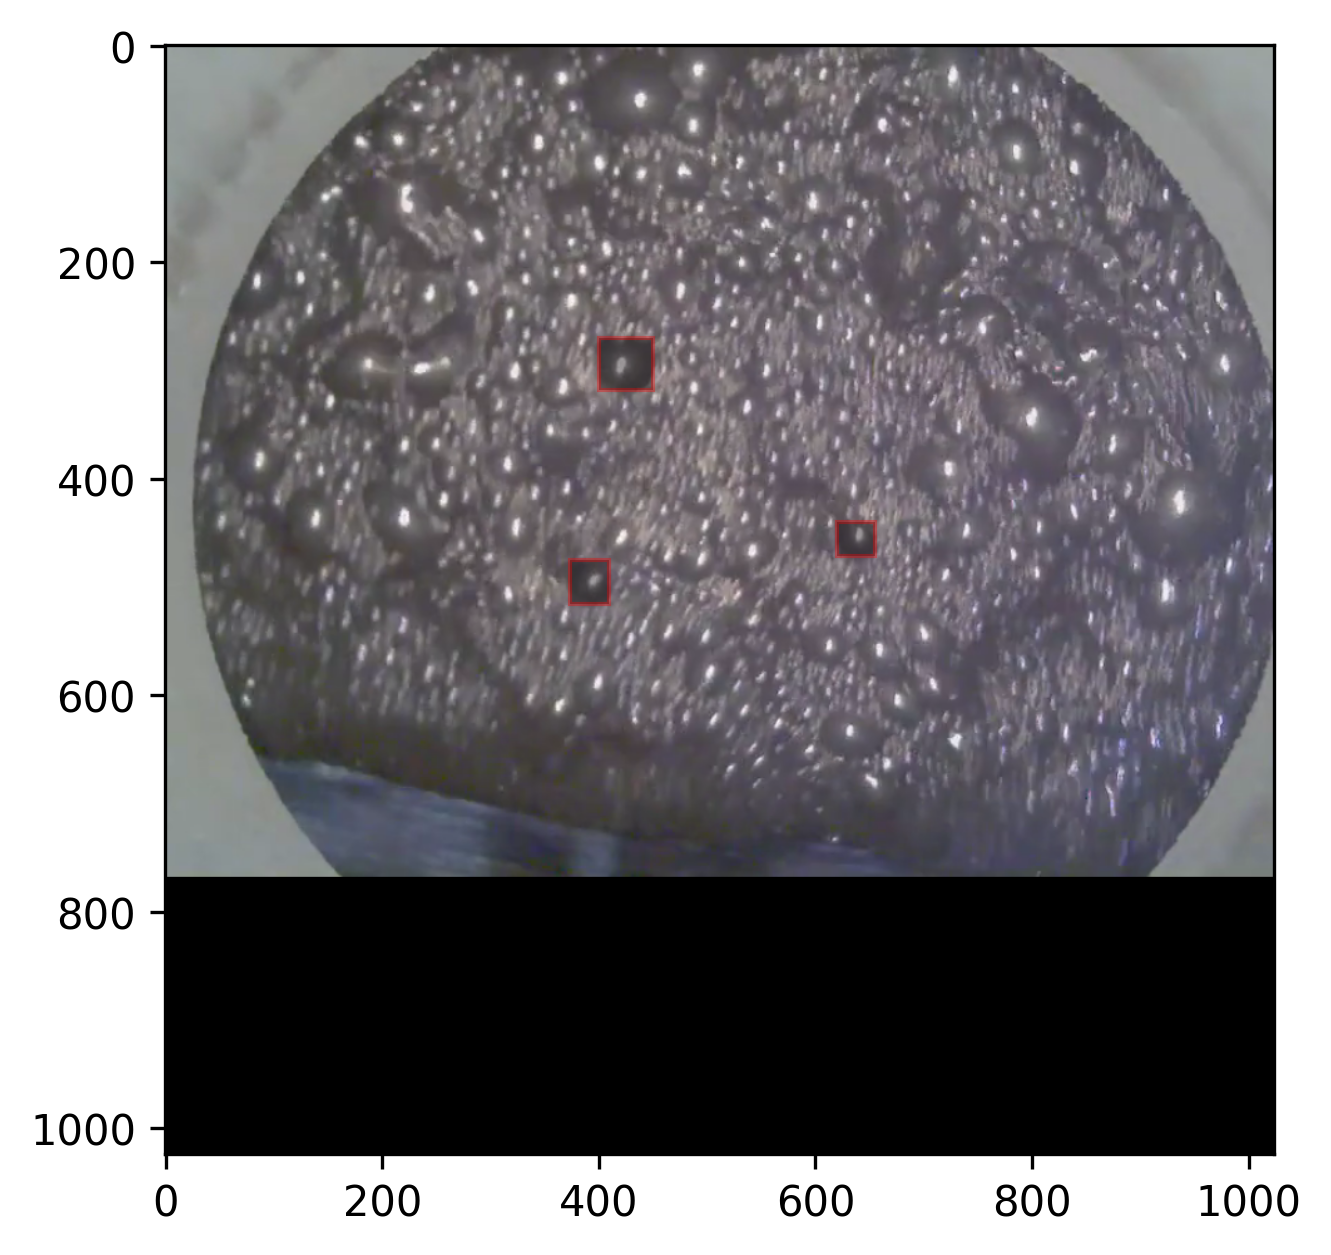

In [ ]:
plot_results(read_image(fname_bubbles),
    bboxes=example_boxes,
             )

In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
with torch.no_grad():
    new_image = transform(image).unsqueeze(0).cuda()
    features = sam.image_encoder(new_image)

In [ ]:
from models import PointDecoder
point_decoder = PointDecoder(sam).cuda().eval()
state_dict = torch.load(f'{project_root}/data/fsc147/checkpoints/point_decoder_vith.pth',
                        map_location='cpu', weights_only=True)
point_decoder.load_state_dict(state_dict)
with torch.no_grad():
    point_decoder.max_points = 1000
    point_decoder.point_threshold = 0.05
    point_decoder.nms_kernel_size = 3
    outputs_heatmaps = point_decoder(features)
    pred_heatmaps = outputs_heatmaps['pred_heatmaps'].cpu().squeeze().clamp(0, 1)

torch.Size([657, 2])


(-0.5, 1023.5, 1023.5, -0.5)

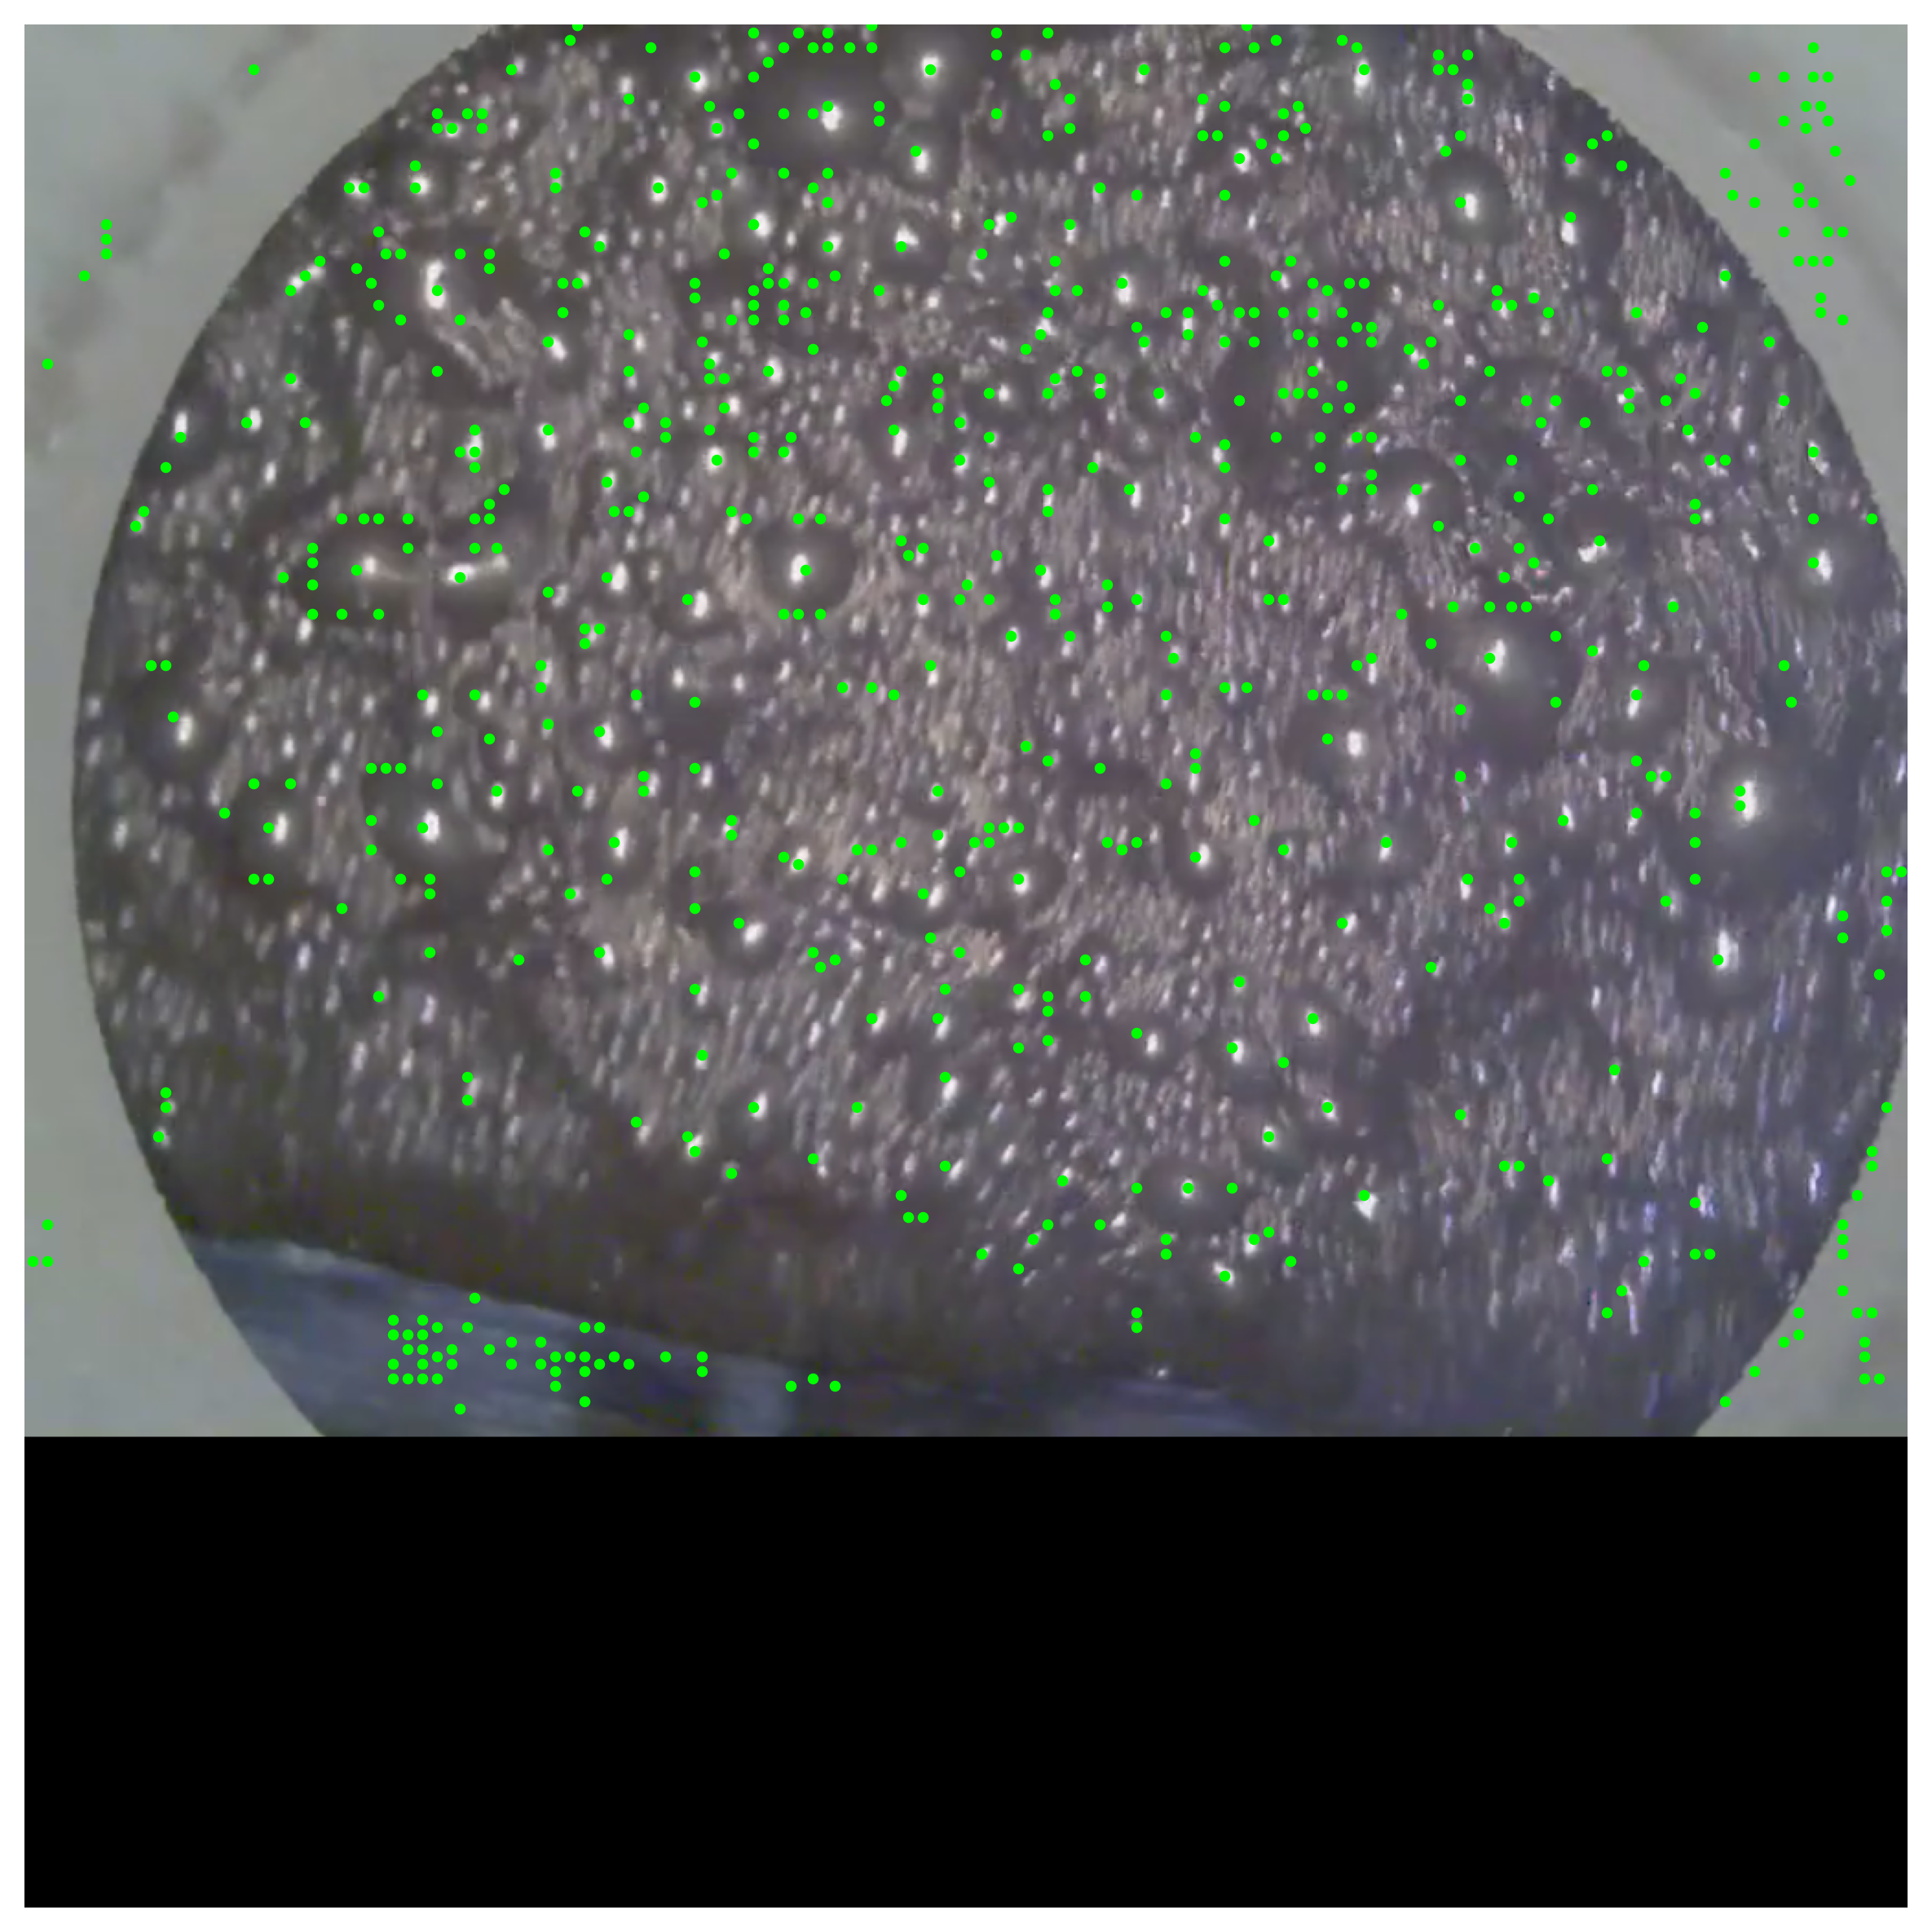

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
pred_points = outputs_heatmaps['pred_points'].squeeze().reshape(-1, 2)
pred_points_score = outputs_heatmaps['pred_points_score'].squeeze()
print(pred_points.size())
plt.scatter(pred_points[:, 0].cpu(), pred_points[:, 1].cpu(), s=20, marker='.', c='lime')
plt.axis('off')

In [ ]:
print(sam.image_encoder.pos_embed.shape)

torch.Size([1, 64, 64, 1280])


In [ ]:
import cv2
import time
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from models import ROIHeadMLP as ROIHead
from ops.dump_clip_features import dump_clip_image_features
from ops.foundation_models.segment_anything import build_sam_vit_h
from models import PointDecoder
from PIL import Image
import numpy as np
import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
project_root = './PseCo'
sam = build_sam_vit_h().to(device).eval()
cls_head = ROIHead().to(device).eval()

/content/PseCo/ops/foundation_models/segment_anything/build_sam.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location="cpu")


In [ ]:
state_dict = torch.load(f'{project_root}/data/fsc147/checkpoints/MLP_small_box_w1_fewshot.tar', map_location=device)
cls_head.load_state_dict(state_dict['cls_head'], strict=False)

point_decoder = PointDecoder(sam).to(device).eval()
state_dict = torch.load(f'{project_root}/data/fsc147/checkpoints/point_decoder_vith.pth', map_location=device)
point_decoder.load_state_dict(state_dict)

def resize_image(image):
    transform = A.Compose([
        A.Resize(1024, 1024),
        A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT)
    ])
    return Image.fromarray(transform(image=np.array(image))['image'])

def process_frame(frame):
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = resize_image(img)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = sam.image_encoder(img_tensor)
        outputs_heatmaps = point_decoder(features)
        pred_points = outputs_heatmaps['pred_points'].squeeze().reshape(-1, 2).cpu().numpy()

    for (x, y) in pred_points:
        cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 0), -1)
    return frame, pred_points

def compute_optical_flow(prev_frame, curr_frame, prev_points):
    if prev_points is None or len(prev_points) == 0:
        return np.array([]), np.array([])

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    new_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_points.astype(np.float32), None)
    valid_points = new_points[status.flatten() == 1]
    prev_points = prev_points[status.flatten() == 1]
    return prev_points, valid_points

def process_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width, height = int(cap.get(3)), int(cap.get(4))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    prev_frame, prev_points = None, None
    total_vectors = []
    start_time = time.time()
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_start_time = time.time()
        processed_frame, points = process_frame(frame)

        if prev_frame is not None:
            prev_pts, new_pts = compute_optical_flow(prev_frame, processed_frame, prev_points)
            if len(prev_pts) > 0:
                movement_vectors = new_pts - prev_pts
                total_vectors.extend(movement_vectors)
        prev_frame, prev_points = frame, points
        out.write(processed_frame)
        frame_count += 1
    cap.release()
    out.release()
    end_time = time.time()
    total_time = end_time - start_time
    avg_vector = np.mean(total_vectors, axis=0) if total_vectors else [0, 0]
    fps_actual = frame_count / total_time

    print(f"Время работы: {total_time:.2f} секунд")
    print(f"Средний вектор перемещения: {avg_vector}")
    print(f"Средний FPS: {fps_actual:.2f}")

input_video = "/content/input_yolov5.mp4"
output_video = "output.mp4"
process_video(input_video, output_video)

<ipython-input-25-ec8ac570bc8f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{project_root}/data/fsc147/checkpoints/MLP_small_box_w1_fewshot.ta

Время работы: 190.78 секунд
Средний вектор перемещения: [-2.5975845 11.197686 ]
Средний FPS: 0.52
